# FiveThirtyEight Riddler: Marathon Running Buddies
https://fivethirtyeight.com/features/how-hard-is-it-to-find-a-running-buddy/

Extra credit!!!

### Import libraries

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import norm
from scipy.optimize import curve_fit
import pandas as pd
import time
%matplotlib inline

### Load in the data
Obtained from https://www.kaggle.com/rojour/boston-results/version/4

In [3]:
df = pd.read_csv('data/marathon_results_2015.csv')
df.head()

,Unnamed: 0,Bib,Name,Age,M/F,City,State,Country,Citizen,Unnamed: 9,...,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender,Division
0,0,3,"Desisa, Lelisa",25,M,Ambo,NaN,ETH,NaN,NaN,...,1:16:07,1:32:00,1:47:59,2:02:39,0:04:56,-,2:09:17,1,1,1
1,1,4,"Tsegay, Yemane Adhane",30,M,Addis Ababa,NaN,ETH,NaN,NaN,...,1:16:07,1:31:59,1:47:59,2:02:42,0:04:58,-,2:09:48,2,2,2
2,2,8,"Chebet, Wilson",29,M,Marakwet,NaN,KEN,NaN,NaN,...,1:16:07,1:32:00,1:47:59,2:03:01,0:04:59,-,2:10:22,3,3,3
3,3,11,"Kipyego, Bernard",28,M,Eldoret,NaN,KEN,NaN,NaN,...,1:16:07,1:32:00,1:48:03,2:03:47,0:05:00,-,2:10:47,4,4,4
4,4,10,"Korir, Wesley",32,M,Kitale,NaN,KEN,NaN,NaN,...,1:16:07,1:32:00,1:47:59,2:03:27,0:05:00,-,2:10:49,5,5,5


In [4]:
df.columns

Index(['Unnamed: 0', 'Bib', 'Name', 'Age', 'M/F', 'City', 'State', 'Country',
       'Citizen', 'Unnamed: 9', '5K', '10K', '15K', '20K', 'Half', '25K',
       '30K', '35K', '40K', 'Pace', 'Proj Time', 'Official Time', 'Overall',
       'Gender', 'Division'],
      dtype='object')

### Parse the data
Convert all times into seconds, and create a new column indicating which wave the runner started in. This is indicated by the bib number (note that this is the assigned wave; runners can move back if they want).

Knowing the wave assignment is important if we're trying to find evidence of buddies-- as a first pass, we should really only compare runners in the same wave.

Also, for these purposes, I'm ignoring "elite" runners (bib # < 101).

In [5]:
time_cols=['5K', '10K', '15K', '20K', 'Half', '25K','30K', '35K', '40K', 'Pace', 'Official Time']
for col in time_cols:
    df[col+'_sec'] = pd.to_timedelta(df[col]).map(lambda x: x.seconds)
    df[col+'_sec'] = df[col+'_sec'].map(lambda x: x if x>0 else np.nan)

# convert bib number string to a number
def str2int(x):
    try:
        y = int(x)
    except:
        y = np.nan
    return y
df['Bib'] = df['Bib'].map(str2int)

# https://registration.baa.org/2015/cf/public/iframe_EntryLists.cfm
def wavefinder(b):
    if np.isnan(b) or b < 101: # these are the elites; should ignore for these purposes
        return 0
    if b > 101 and b < 7700:
        return 1
    if b > 8000 and b < 15600:
        return 2
    if b > 16000 and b < 23600:
        return 3
    if b > 24000 and b < 32500:
        return 4
    return 0

df['Wave'] = df['Bib'].map(wavefinder)

## Calculate speeds
It absolutely does not take a PhD in physics to do this, but it can't hurt, right?

### 10k speeds
For each of the four waves, calculate each runner's average speed after 10km. Plot the distributions, fit gaussians (a la the Riddler), and show the maximum likelihood estimators for normal mean and std dev.

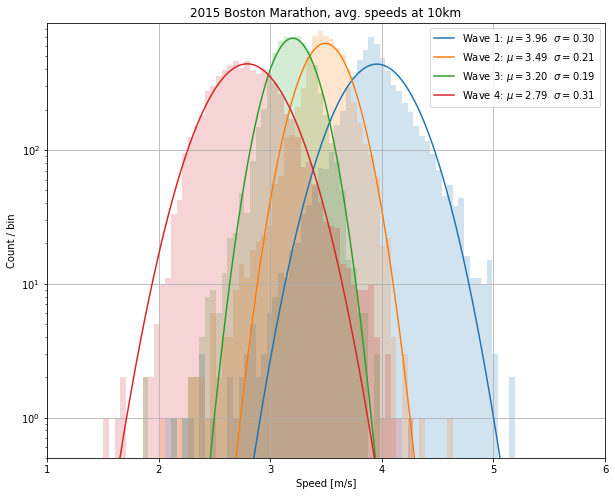

In [6]:
f, ax = plt.subplots(figsize=(10,8))
waves = [1,2,3,4]
y_max = []

color_norm = mpl.colors.BoundaryNorm(np.array([1,2,3,4,5]),4)
cmap = plt.cm.get_cmap('tab10')
#color_norm = mpl.colors.Normalize(vmin=1,vmax=4)
#cmap = plt.cm.get_cmap('viridis')

for idx,wave in enumerate(waves):
    speeds = (10000/df.loc[df['Wave']==wave,'10K_sec'])
    bins = np.linspace(1,6,100)
    binwidth = bins[1]-bins[0]
    speeds.hist(bins=bins, alpha=.2, color=cmap(color_norm(wave)))
    x = np.linspace(0,6,1000)
    #y = norm.pdf(x,loc=speeds.mean(),scale=speeds.std()) # method of moments
    loc,scale = norm.fit(speeds.dropna()) # MLEs
    y = norm.pdf(x,loc=loc,scale=scale)
    y_scale = y*speeds.count()*binwidth
    leg_txt = 'Wave %d: $\mu=$%.2f  $\sigma=$%.2f ' % (wave,loc,scale)
    ax.plot(x,y_scale,color=cmap(color_norm(wave)),label=leg_txt)
    y_max.append(np.max(y_scale))

ax.set_yscale('log')
ax.set_ylim([.5,1.3*np.max(y_max)])
ax.set_xlim([1,6])
ax.legend()
ax.set_title('2015 Boston Marathon, avg. speeds at 10km')
ax.set_xlabel('Speed [m/s]')
ax.set_ylabel('Count / bin')

Though there are some deviations from gaussianity (asymmetric tails, and wave 1 has some interesting structure), it's not a bad model. For the different waves, average speeds range from 2.8 m/s (6.3 mph) to 4.0 m/s (8.9 mph). Standard deviations within the waves are between 0.2 and 0.3 m/s.

### Full marathon speeds
Same deal, but looking at average speeds over the full race.

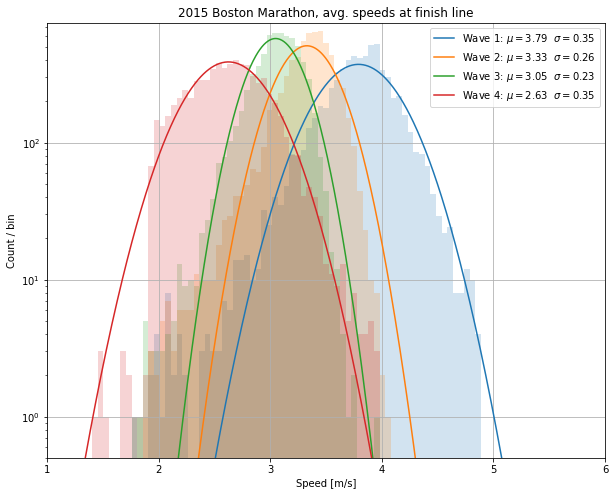

In [7]:
f, ax = plt.subplots(figsize=(10,8))
waves = [1,2,3,4]
y_max = []

color_norm = mpl.colors.BoundaryNorm(np.array([1,2,3,4,5]),4)
cmap = plt.cm.get_cmap('tab10')
#color_norm = mpl.colors.Normalize(vmin=1,vmax=4)
#cmap = plt.cm.get_cmap('viridis')

for idx,wave in enumerate(waves):
    speeds = (42195/df.loc[df['Wave']==wave,'Official Time_sec'])
    bins = np.linspace(1,6,100)
    binwidth = bins[1]-bins[0]
    speeds.hist(bins=bins, alpha=.2, color=cmap(color_norm(wave)))
    x = np.linspace(0,6,1000)
    #y = norm.pdf(x,loc=speeds.mean(),scale=speeds.std()) # method of moments
    loc,scale = norm.fit(speeds.dropna()) # MLEs
    y = norm.pdf(x,loc=loc,scale=scale)
    y_scale = y*speeds.count()*binwidth
    leg_txt = 'Wave %d: $\mu=$%.2f  $\sigma=$%.2f ' % (wave,loc,scale)
    ax.plot(x,y_scale,color=cmap(color_norm(wave)),label=leg_txt)
    y_max.append(np.max(y_scale))

ax.set_yscale('log')
ax.set_ylim([.5,1.3*np.max(y_max)])
ax.set_xlim([1,6])
ax.legend()
ax.set_title('2015 Boston Marathon, avg. speeds at finish line')
ax.set_xlabel('Speed [m/s]')
ax.set_ylabel('Count / bin')

As you might expect, runners tend to slow down a bit (average decreases by roughly .2 m/s in each wave), and the distributions are a bit more smeared out.

## Who has buddies?

Now let's take a quick look at how runners buddy up. There's a lot of potential routes of exploration. I'm only gonna scratch the surface here. First let's look at how runners that were grouped together at 5K disperse over the course of the race:

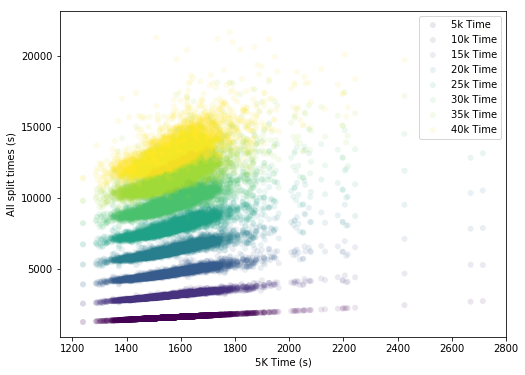

In [212]:
dists = np.linspace(start=5,stop=40,endpoint=True,num=40//5,dtype=int)
cols = [str(d)+'K_sec' for d in dists]

color_norm = mpl.colors.Normalize(vmin=dists.min(),vmax=dists.max())
cmap = plt.cm.get_cmap('viridis')
f, ax = plt.subplots(figsize=(8,6))

times_x = (df.loc[df['Wave']==3,'5K_sec']).dropna()

for idx,d in enumerate(dists): 
    times=(df.loc[times_x.index,cols[idx]])    
    leg_txt = '%dk Time' % d
    ax.scatter(times_x,times,alpha=.1,color=cmap(color_norm(d)),edgecolors='None',label=leg_txt)
    
#ax.set_xscale('log')
#ax.set_ylim([-.5,10])
ax.legend()
ax.set_xlabel('5K Time (s)')
ax.set_ylabel('All split times (s)')

Now, let's try to find running buddies that stay relatively close to eachother throughout the race. To do this, I'll see who's neck in neck at 40km, and then average the differences of their split times to see if they had similar space-time trajectories.

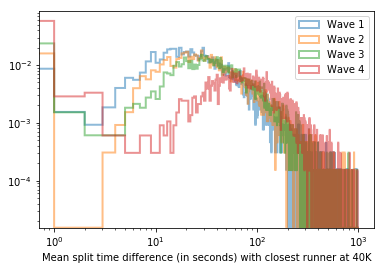

In [247]:
dists = np.linspace(start=5,stop=40,endpoint=True,num=40//5,dtype=int)
cols = [str(d)+'K_sec' for d in dists]

for wave in [1,2,3,4]:
    df_times = (df.loc[df['Wave']==wave,cols]).dropna(how='any')
    df_times.sort_values(by=cols[::-1],inplace=True)

    df_times['before'] = df_times[cols].diff().abs().mean(axis=1,skipna=False)
    df_times['after'] = df_times[cols].diff(periods=-1).abs().mean(axis=1,skipna=False)

    df_times['closest'] = df_times[['before','after']].min(axis=1)
    leg_txt = 'Wave %d' % wave
    plt.hist(df_times['closest'],bins=np.linspace(0,1000,1000),
             alpha=.5,histtype='step',linewidth=2,normed=True,log=True, label=leg_txt)
plt.gca().set_xlabel('Mean split time difference (in seconds) with closest runner at 40K')
plt.gca().set_xscale('log')
plt.gca().legend()

Interesting to see that the more competitive waves had a smaller relative proportion of runners with race-long buddies. In Wave 1, fewer than 1% of runners ran with the same companions until 40km. For Wave 4, that fraction rises to ~6%.